In [1]:
#Mesa Sismica ST1D
#modelo com sistema 1DOF acoplado

import os
import numpy as np
import matplotlib.pyplot as plt   # MATLAB plotting functions
import control as ct
from control.matlab import *  # MATLAB-like functions
import math


#Servo-valve parameters
tsv=0.0246      #Valve time constant (tsv=0.0246 s)
ksvkq=1934.5    #Valve flow gain (ksvkq=1934.5 cm3/s/V)
kpl=1.67401e-7  #Valve pressure gain & leakadge factor (kpl=1.67401e-7 m3/s/kPa)
Be=193716.28    #Oil Bulk modulus (Be=193716.28 kPa)
Vt=0.002659     #Oil Volume on actuator chamber (Vt=0.002659 m3)
A=0.012456      #Piston area (A=0.012456 m2)
mp=1.9751       #Platen mass (mp=1.9751 t)
ctm=5.78        #Total damping, actuator + platen (ct=5.78 kN s/m)
kh=4*Be*A**2/Vt #(kPa m)

#Additional 1DOF model
msp=2                             #Rigid mass (t)
fn1dof=2                          #Natural frequency (Hz)
zeta1dof=0.02                     #damping ratio (2%)
wn1dof=2*math.pi*fn1dof           #Natural frequency (rad/s)
cct=2*msp*wn1dof                  #critical damping (t/s)
csp=zeta1dof*cct                  #damping (t/s)
ksp=wn1dof**2*msp                 #stiffness (t/s^2)

s=tf('s')

#-------------1DOF model: xsp/xp-----------------------
Hsp=-msp*s*s/(msp*s*s+csp*s+ksp)
mt=mp+msp*(1+Hsp)
#mt=mp+msp      #massa rigida

#-----------------1DOFmodel -> SS model variaveis z={xsp,xp,dot_xsp,dot_xp}---------------------------
#Sistema SS: dz/dt=A*z+B*f; y=Ci*z+D*f
#M,C,K, com variáveis {Xsp=xs-xp; Xp}, entrada força atuador - fp
Mmsp=[[msp, msp], [msp, msp+mp]]
Cmsp=[[csp, 0], [0, ctm]]
Kmsp=[[ksp, 0], [0, 0]]
Gmsp=[[0],[1]]
n=np.size(Kmsp,1)
#As=[zeros(n),eye(n);-M^-1*K,M^-1*C]
As=np.zeros([2*n,2*n])
As[0:n,n:2*n+1]=np.eye(n)
As[n:2*n+1,0:n]=np.dot(-np.linalg.inv(Mmsp),Kmsp)
As[n:2*n+1,n:2*n+1]=np.dot(-np.linalg.inv(Mmsp),Cmsp)
#Bs
Bs=np.zeros([2*n,1]); Bs[n:2*n+1]=np.dot(np.linalg.inv(Mmsp),Gmsp)
#Cs= todos os estados (desl. e velocidade)
Cs=np.eye(2*n); Ds=np.zeros([2*n,1])
#Cs=np.zeros([n,2*n]);Cs[0:n,0:n]=np.eye(n); Ds=np.zeros([n,1])
#sistema
Hspss=ct.matlab.ss(As,Bs,Cs,Ds,inputs=['fp'], outputs=['xsp','xp','d/dt_xsp','d/dt_xp'], states=['xsp','xp','d/dt_xsp','d/dt_xp'])

#xsp/xp
#Xsp/f
Hspss_1=ct.ss(As,Bs,Cs[0,0:2*n],Ds[0,0])
Hspss_1tf=ct.ss2tf(Hspss_1)
#Xp/f
Hspss_2=ct.ss(As,Bs,Cs[1,0:2*n],Ds[1,0])
Hspss_2tf=ct.ss2tf(Hspss_2)
#xsp/xp
Hspss_tf=minreal(Hspss_1tf/Hspss_2tf)

#ct.damp(Hspss_tf)


#--------------1DOFmodel -> SS model variaveis z={xs,xp,dot_xs,dot_xp} ----------------------------
#NOTA: este modelo coloca um polo próximo da origem mas positivo, o que torna o sistema numericamente instavel
#Sistema SS: dz/dt=A*z+B*f; y=Ci*z+D*f
#M,C,K, com variáveis {Xs; Xp}, entrada força atuador - fp
Mmsp2=[[msp, 0], [0, mp]]
Cmsp2=[[csp, -csp], [-csp, csp+ctm]]
Kmsp2=[[ksp, -ksp], [-ksp, ksp]]
Gmsp2=[[0],[1]]
n=np.size(Kmsp2,1)
#As=[zeros(n),eye(n);-M^-1*K,M^-1*C]
As2=np.zeros([2*n,2*n])
As2[0:n,n:2*n+1]=np.eye(n)
As2[n:2*n+1,0:n]=np.dot(-np.linalg.inv(Mmsp2),Kmsp2)
As2[n:2*n+1,n:2*n+1]=np.dot(-np.linalg.inv(Mmsp2),Cmsp2)
#Bs
Bs2=np.zeros([2*n,1]); Bs2[n:2*n+1]=np.dot(np.linalg.inv(Mmsp2),Gmsp2)
#Cs= todos os estados (desl. e velocidade)
Cs2=np.eye(2*n); Ds2=np.zeros([2*n,1])
#Cs=np.zeros([n,2*n]);Cs[0:n,0:n]=np.eye(n); Ds=np.zeros([n,1])
#sistema
Hspss2=ct.ss(As2,Bs2,Cs2,Ds2)

#xsp/xp
#Xsp/f
Hspss2_1=ct.ss(As2,Bs2,Cs2[0,0:2*n]-Cs2[1,0:2*n],Ds2[0,0])
Hspss2_1tf=ct.ss2tf(Hspss2_1)
#Xp/f
Hspss2_2=ct.ss(As2,Bs2,Cs2[1,0:2*n],Ds2[2,0]) #equivalente a Hspss2_2[1,0]
Hspss2_2tf=ct.ss2tf(Hspss2_2)
#xsp/xp
Hspss2_tf=minreal(Hspss2_1tf/Hspss2_2tf)


#FT do anel aberto Gaa=xp/isv
Gaa=10**-4*A*kh*ksvkq/(s*(s*tsv + 1)*(A**2*ctm*s + A**2*kh + A**2*mt*s**2 + kpl*ctm*kh + kpl*kh*mt*s))
Gaa2=minreal(Gaa)     #reducao do modelo

#FT do anel aberto Gaa=xp/isv com MASSA RIGIDA
Gaa_r=10**-4*A*kh*ksvkq/(s*(s*tsv + 1)*(A**2*ctm*s + A**2*kh + A**2*(mp+msp)*s**2 + kpl*ctm*kh + kpl*kh*mt*s))
Gaa_r2=minreal(Gaa_r)     #reducao do modelo


3 states have been removed from the model
3 states have been removed from the model
2 states have been removed from the model
0 states have been removed from the model


In [2]:
#Hspss
Hspss[1,0]


StateSpace(array([[   0.        ,    0.        ,    1.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ],
       [-317.81815163,    0.        ,   -1.0116466 ,    2.9264341 ],
       [ 159.90448121,    0.        ,    0.50899177,   -2.9264341 ]]), array([[ 0.        ],
       [ 0.        ],
       [-0.50630348],
       [ 0.50630348]]), array([[0., 1., 0., 0.]]), array([[0.]]))

In [3]:
#xsp/xp com SS model variaveis z={xsp,xp,dot_xsp,dot_xp}
minreal(Hspss_tf)

0 states have been removed from the model


TransferFunction(array([-1.00000000e+00,  4.36621597e-14, -3.72885819e-28]), array([  1.        ,   0.50265482, 157.91367042]))

In [4]:
#xsp/xp com SS model variaveis z={xs,xp,dot_xs,dot_xp}
minreal(Hspss2_tf)

0 states have been removed from the model


TransferFunction(array([-1.00000000e+00, -9.69871795e-14,  2.84829489e-27]), array([  1.        ,   0.50265482, 157.91367042]))

In [5]:
#xsp/xp com FT model Hsp
minreal(Hsp)

0 states have been removed from the model


TransferFunction(array([-1., -0., -0.]), array([  1.        ,   0.50265482, 157.91367042]))

In [6]:
#polos xsp/xp com SS model variaveis z={xsp,xp,dot_xsp,dot_xp}
ct.damp(Hspss_tf)

    Eigenvalue (pole)       Damping     Frequency
   -0.2513    +12.56j          0.02         12.57
   -0.2513    -12.56j          0.02         12.57


(array([12.56637061, 12.56637061]),
 array([0.02, 0.02]),
 array([-0.25132741+12.56385709j, -0.25132741-12.56385709j]))

In [7]:
#polos SS model variaveis z={xs,xp,dot_xs,dot_xp}
ct.damp(Hspss2_tf)

    Eigenvalue (pole)       Damping     Frequency
   -0.2513    +12.56j          0.02         12.57
   -0.2513    -12.56j          0.02         12.57


(array([12.56637061, 12.56637061]),
 array([0.02, 0.02]),
 array([-0.25132741+12.56385709j, -0.25132741-12.56385709j]))

In [8]:
#polos modelo FT Hsp
ct.damp(Hsp)

    Eigenvalue (pole)       Damping     Frequency
   -0.2513    +12.56j          0.02         12.57
   -0.2513    -12.56j          0.02         12.57


(array([12.56637061, 12.56637061]),
 array([0.02, 0.02]),
 array([-0.25132741+12.56385709j, -0.25132741-12.56385709j]))

In [9]:
#polos SS model variaveis z={xsp,xp,dot_xsp,dot_xp}
ct.damp(Hspss)

    Eigenvalue (pole)       Damping     Frequency
                    0             1             0
    -1.237    +17.72j       0.06963         17.77
    -1.237    -17.72j       0.06963         17.77
               -1.464             1         1.464


C:\Users\fvoliveira\AppData\Local\anaconda3\Lib\site-packages\control\lti.py:57: RuntimeWarning: invalid value encountered in divide
  zeta = -real(splane_poles)/wn


(array([ 0.        , 17.76702351, 17.76702351,  1.46395971]),
 array([       nan, 0.06962677, 0.06962677, 1.        ]),
 array([ 0.         +0.j        , -1.2370605 +17.72390492j,
        -1.2370605 -17.72390492j, -1.46395971 +0.j        ]))

In [10]:
#polos SS model variaveis z={xs,xp,dot_xs,dot_xp}
ct.damp(Hspss2)

    Eigenvalue (pole)       Damping     Frequency
    -1.237    +17.72j       0.06963         17.77
    -1.237    -17.72j       0.06963         17.77
               -1.464             1         1.464
           -1.419e-14             1     1.419e-14


(array([1.77670235e+01, 1.77670235e+01, 1.46395971e+00, 1.41861743e-14]),
 array([0.06962677, 0.06962677, 1.        , 1.        ]),
 array([-1.23706050e+00+17.72390492j, -1.23706050e+00-17.72390492j,
        -1.46395971e+00 +0.j        , -1.41861743e-14 +0.j        ]))

In [11]:
#zeros de xp/f são os polos de xsp/xp
ct.zeros(Hspss_2tf)

array([-0.25132741+12.56385709j, -0.25132741-12.56385709j])

In [12]:
#xp/f
minreal(Hspss_2tf)

0 states have been removed from the model


TransferFunction(array([ 0.50630348,  0.25449589, 79.9522406 ]), array([ 1.00000000e+00,  3.93808070e+00,  3.19289138e+02,  4.62123951e+02,
       -5.38247684e-12]))

In [13]:
#zeros de xp/f são os polos de xsp/xp
ct.zeros(Hspss2_2tf)

array([-0.25132741+12.56385709j, -0.25132741-12.56385709j])

In [14]:
#xp/f
minreal(Hspss2_2tf)

0 states have been removed from the model


TransferFunction(array([ 0.50630348,  0.25449589, 79.9522406 ]), array([ 1.00000000e+00,  3.93808070e+00,  3.19289138e+02,  4.62123951e+02,
       -1.09139364e-11]))

array([[list([<matplotlib.lines.Line2D object at 0x000001E01B7E8810>]),
        list([<matplotlib.lines.Line2D object at 0x000001E01B85A3D0>])]],
      dtype=object)

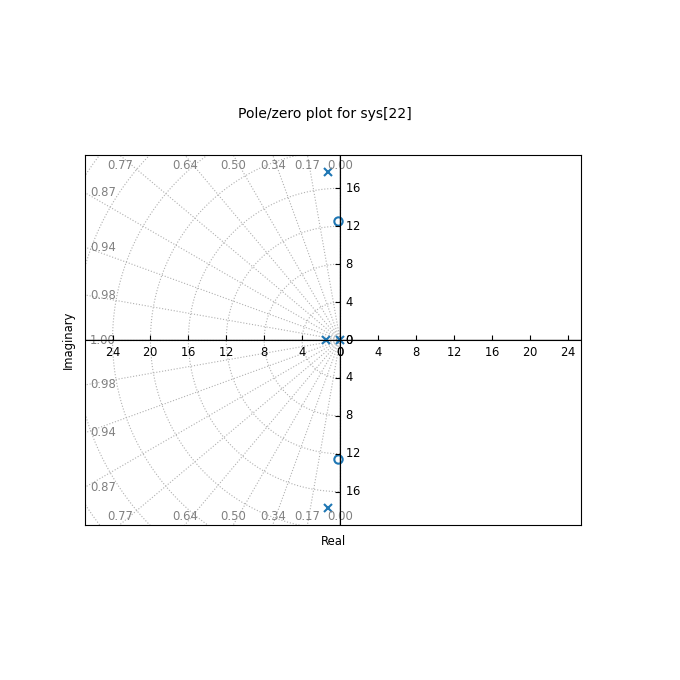

In [15]:
#Sistema Controlado xp/f
ct.pzmap(Hspss_2tf, grid='true')

In [16]:
sv_sys=ct.tf(ksvkq, [tsv, 1], inputs='isv', outputs='xsva')
vfeed_sys=ct.tf(A, 1, inputs='d/dt_xp', outputs='vpa')
v_error = ct.summing_junction(inputs=['xsva', '-vpa'], output='verror')
pl_sys=ct.tf(kh, [A**2,kh*kpl], inputs='verror', outputs='pl')
fp_sys=ct.tf(A, 1, inputs='pl', outputs='fp')
#sys1_aa=ct.interconnect([sv_sys, vfeed_sys, pl_sys, fp_sys, v_error], inputs=['isv','d/dt_xp'], outputs='fp')
sys_aa=ct.interconnect([sv_sys, vfeed_sys, pl_sys, fp_sys, Hspss, v_error], inputs='isv', outputs='xp')

C:\Users\fvoliveira\AppData\Local\anaconda3\Lib\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (4, 0) : sys[18].xsp; (4, 2) : sys[18].d/dt_xsp
  warn(msg)


In [17]:
#sv_sys
#vfeed_sys
#tf2ss(vfeed_sys)
#tf2ss(s)
#pl_sys
#fp_sys
sys_aa

StateSpace(array([[-4.06504065e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.86382114e+06, -4.87826987e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.24560000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -1.83779593e+02, -3.17818152e+02,
         0.00000000e+00, -1.01164660e+00,  2.92643410e+00],
       [ 0.00000000e+00,  1.83779593e+02,  1.59904481e+02,
         0.00000000e+00,  5.08991772e-01, -2.92643410e+00]]), array([[100.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.]]), array([[0., 0., 0., 1., 0., 0.]]), array([[0.]]))

In [18]:
#polos do sistema em anel aberto
ct.damp(sys_aa)

    Eigenvalue (pole)       Damping     Frequency
                    0             1             0
    -25.94    +150.1j        0.1703         152.3
    -25.94    -150.1j        0.1703         152.3
   -0.4183    +12.51j       0.03341         12.52
   -0.4183    -12.51j       0.03341         12.52
               -40.65             1         40.65


C:\Users\fvoliveira\AppData\Local\anaconda3\Lib\site-packages\control\lti.py:57: RuntimeWarning: invalid value encountered in divide
  zeta = -real(splane_poles)/wn


(array([  0.        , 152.32469805, 152.32469805,  12.52066731,
         12.52066731,  40.6504065 ]),
 array([       nan, 0.17030794, 0.17030794, 0.0334075 , 0.0334075 ,
        1.        ]),
 array([  0.          +0.j        , -25.94210558+150.09936973j,
        -25.94210558-150.09936973j,  -0.41828415 +12.51367845j,
         -0.41828415 -12.51367845j, -40.6504065   +0.j        ]))

array([[list([<matplotlib.lines.Line2D object at 0x000001E01BBB49D0>]),
        list([<matplotlib.lines.Line2D object at 0x000001E01B8569D0>])]],
      dtype=object)

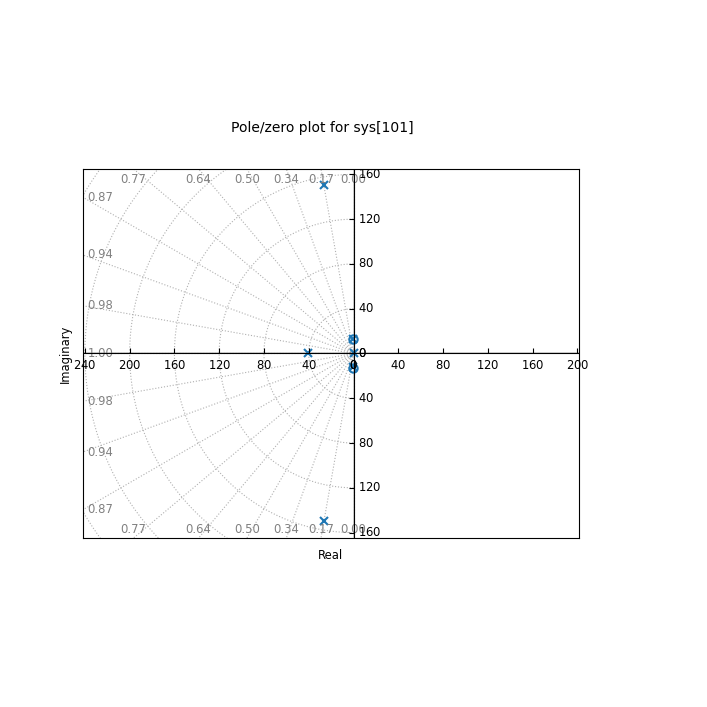

In [19]:
#Sistema Controlado xp/isv com modelo 1DOF 
ct.pzmap(sys_aa, grid='true')

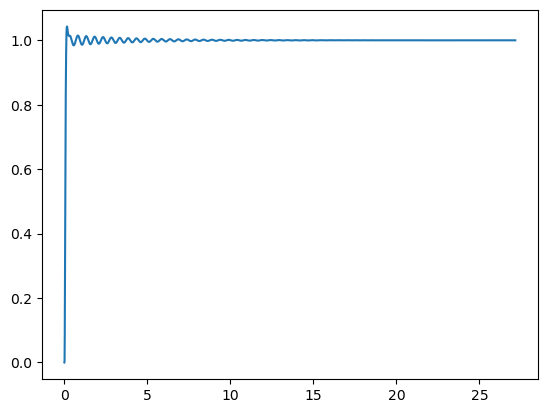

RiseTime: 0.06519804114311696
SettlingTime: 2.336263140961691
SettlingMin: 0.9008796293333656
SettlingMax: 1.0429275016099926
Overshoot: 4.292750160999282
Undershoot: 0
Peak: 1.0429275016099926
PeakTime: 0.15756193276253264
SteadyStateValue: 0.9999999999999998


In [20]:
#Resposta ao degrau do anel fechado

#anel fechado
kp=1.2993*10**-4      #Pgain (kp=1.2993 V/cm) #fator 10^-4 vem da conversão de unidades
controller=ct.tf(kp, 1, inputs='error', outputs='isv') #controlador prop 'kp'
error = ct.summing_junction(['xpref', '-xp'], 'error') #
sys_af=ct.interconnect([controller, sys_aa, error], inputs='xpref', outputs='xp')

# Step response for the system
plt.figure(1)
yout, T = step(sys_af)
#yout2, T2 = step(FT2)
#plt.plot(T.T, yout.T,T2.T, yout2.T)
#plt.gca().legend(('FT1','FT2'))
#plt.plot(T2.T, yout2.T)
plt.plot(T.T, yout.T)
plt.show(block=False)


S_FT2 = ct.step_info(sys_af, SettlingTimeThreshold=0.01)
for k in S_FT2:
    print(f"{k}: {S_FT2[k]}")

In [21]:
ct.damp(sys_af)

    Eigenvalue (pole)       Damping     Frequency
    -26.16    +147.3j        0.1749         149.6
    -26.16    -147.3j        0.1749         149.6
    -20.27    +21.07j        0.6934         29.24
    -20.27    -21.07j        0.6934         29.24
   -0.2543    +12.45j       0.02042         12.45
   -0.2543    -12.45j       0.02042         12.45


(array([149.5586026 , 149.5586026 ,  29.2372138 ,  29.2372138 ,
         12.45324858,  12.45324858]),
 array([0.17491122, 0.17491122, 0.69335554, 0.69335554, 0.02042292,
        0.02042292]),
 array([-26.15947697+147.25303859j, -26.15947697-147.25303859j,
        -20.27178429 +21.06820904j, -20.27178429 -21.06820904j,
         -0.25433171 +12.45065121j,  -0.25433171 -12.45065121j]))

array([[list([<matplotlib.lines.Line2D object at 0x000001E01BBF49D0>]),
        list([<matplotlib.lines.Line2D object at 0x000001E01C0968D0>]),
        list([<matplotlib.lines.Line2D object at 0x000001E01C097110>, <matplotlib.lines.Line2D object at 0x000001E01C097890>, <matplotlib.lines.Line2D object at 0x000001E01C09C1D0>, <matplotlib.lines.Line2D object at 0x000001E01C09CA50>, <matplotlib.lines.Line2D object at 0x000001E01C09D150>, <matplotlib.lines.Line2D object at 0x000001E01C09D950>])]],
      dtype=object)

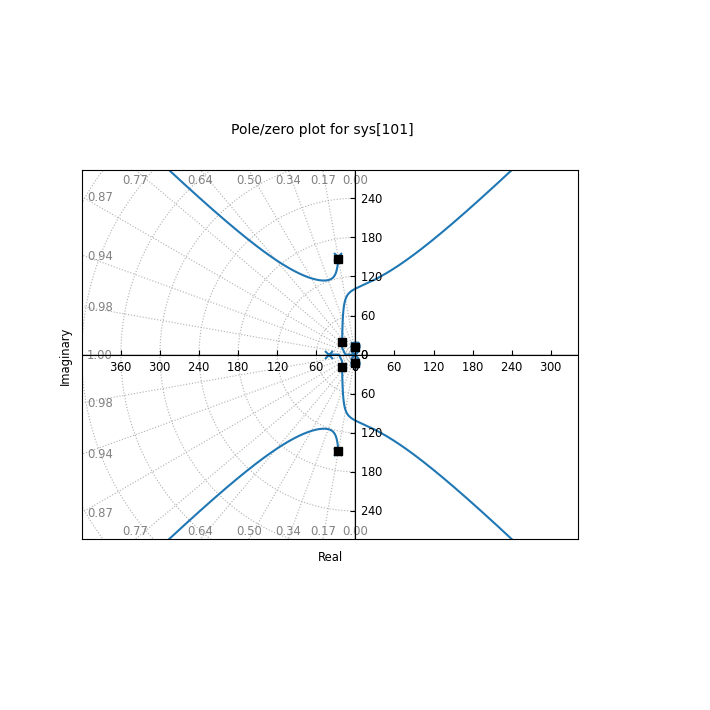

In [22]:
#Sistema não compensado com Controlador Proporcional
#P:  C_f = kc
ct.root_locus(sys_aa,np.linspace(0, 1, num=50000),grid='true',initial_gain=1.2*10**-4) #2DOF

In [23]:
#como Modelo 2DOF
#--------------2DOFmodel -> SS model variaveis z={xs,xp,dot_xs,dot_xp} ----------------------------
#Sistema SS: dz/dt=A*z+B*f; y=Ci*z+D*f

msp1=msp
msp2=msp
csp2=csp
csp1=csp
ksp2=ksp
ksp1=ksp

#M,C,K, com variáveis {Xs2; Xs1; Xp}, entrada força atuador - fp
#NOTA: este modelo coloca um polo próximo da origem mas positivo, o que torna o sistema numericamente instavel
#Mmsp2d=[[msp2, 0, 0], [0, msp1, 0],[0, 0, mp]]
#Cmsp2d=[[csp2,-csp2, 0], [-csp2, csp2+csp1, -csp1], [0,-csp1,csp1+ctm]]
#Kmsp2d=[[ksp2, -ksp2, 0], [-ksp2, ksp2+ksp1,-ksp1],[0,-ksp1,ksp1]]


#M,C,K, com variáveis {Xsp2;Xsp1; Xp}, entrada força atuador - fp
Mmsp2d=[[msp2, 0, msp2], [0, msp1, msp1],[msp2, msp1, mp+msp1+msp2]]
Cmsp2d=[[csp2,-csp2, 0], [-csp2, csp2+csp1, 0], [0,0,ctm]]
Kmsp2d=[[ksp2, -ksp2, 0], [-ksp2, ksp2+ksp1,0],[0,0,0]]

Gmsp2d=[[0],[0],[1]]
n=np.size(Kmsp2d,1)
#As=[zeros(n),eye(n);-M^-1*K,M^-1*C]
As2d=np.zeros([2*n,2*n])
As2d[0:n,n:2*n+1]=np.eye(n)
As2d[n:2*n+1,0:n]=np.dot(-np.linalg.inv(Mmsp2d),Kmsp2d)
As2d[n:2*n+1,n:2*n+1]=np.dot(-np.linalg.inv(Mmsp2d),Cmsp2d)
#Bs
Bs2d=np.zeros([2*n,1]); Bs2d[n:2*n+1]=np.dot(np.linalg.inv(Mmsp2d),Gmsp2d)
#Cs= todos os estados (desl. e velocidade)
Cs2d=np.eye(2*n); Ds2d=np.zeros([2*n,1])
#Cs=np.zeros([n,2*n]);Cs[0:n,0:n]=np.eye(n); Ds=np.zeros([n,1])
#sistema
Hspss2d=ct.ss(As2d,Bs2d,Cs2d,Ds2d,inputs=['fp'], outputs=['xs2','xs1','xp','d/dt_xs2','d/dt_xs1','d/dt_xp'], states=['xs2','xs1','xp','d/dt_xs2','d/dt_xs1','d/dt_xp'])

sys_aa2d=ct.interconnect([sv_sys, vfeed_sys, pl_sys, fp_sys, Hspss2d, v_error], inputs='isv', outputs='xp')

#ct.damp(Hspss2d) #sistema 2DOF
ct.damp(minreal(sys_aa2d)) #sistema sv+at+plat+2DOF


0 states have been removed from the model
    Eigenvalue (pole)       Damping     Frequency
    -25.94    +150.1j        0.1703         152.3
    -25.94    -150.1j        0.1703         152.3
               -40.65             1         40.65
   -0.7033     +20.3j       0.03462         20.31
   -0.7033     -20.3j       0.03462         20.31
   -0.2177    +7.743j        0.0281         7.746
   -0.2177    -7.743j        0.0281         7.746
           -8.788e-16             1     8.788e-16


C:\Users\fvoliveira\AppData\Local\anaconda3\Lib\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (4, 4) : sys[111].d/dt_xs1; (4, 0) : sys[111].xs2; (4, 1) : sys[111].xs1; (4, 3) : sys[111].d/dt_xs2
  warn(msg)


(array([1.52324725e+02, 1.52324725e+02, 4.06504065e+01, 2.03115293e+01,
        2.03115293e+01, 7.74630585e+00, 7.74630585e+00, 8.78811413e-16]),
 array([0.17030799, 0.17030799, 1.        , 0.03462403, 0.03462403,
        0.02809856, 0.02809856, 1.        ]),
 array([-2.59421175e+01+150.09939507j, -2.59421175e+01-150.09939507j,
        -4.06504065e+01  +0.j        , -7.03266971e-01 +20.29935064j,
        -7.03266971e-01 -20.29935064j, -2.17660077e-01  +7.74324727j,
        -2.17660077e-01  -7.74324727j, -8.78811413e-16  +0.j        ]))

In [24]:
ct.zeros(sys_aa2d) #sistema sv+at+plat+2DOF

array([-0.65798371+20.32216556j, -0.65798371-20.32216556j,
       -0.09599853 +7.76585083j, -0.09599853 -7.76585083j])

In [25]:
ct.damp(Hspss2d) #sistema 2DOF

    Eigenvalue (pole)       Damping     Frequency
                    0             1             0
   -0.9986    +21.73j       0.04591         21.75
   -0.9986    -21.73j       0.04591         21.75
   -0.9845    +12.52j       0.07837         12.56
   -0.9845    -12.52j       0.07837         12.56
              -0.9771             1        0.9771


C:\Users\fvoliveira\AppData\Local\anaconda3\Lib\site-packages\control\lti.py:57: RuntimeWarning: invalid value encountered in divide
  zeta = -real(splane_poles)/wn


(array([ 0.        , 21.75263615, 21.75263615, 12.56333899, 12.56333899,
         0.9771118 ]),
 array([       nan, 0.04590709, 0.04590709, 0.07836603, 0.07836603,
        1.        ]),
 array([ 0.         +0.j        , -0.99860024+21.72970265j,
        -0.99860024-21.72970265j, -0.98453904+12.52470237j,
        -0.98453904-12.52470237j, -0.9771118  +0.j        ]))

array([[list([<matplotlib.lines.Line2D object at 0x000001E01C01DE10>]),
        list([<matplotlib.lines.Line2D object at 0x000001E01C00DB10>])]],
      dtype=object)

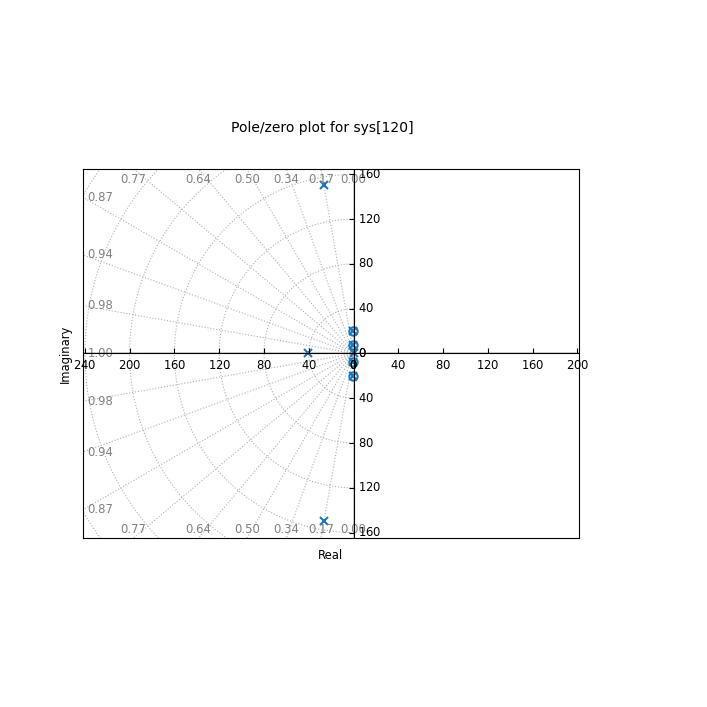

In [26]:
#Sistema Controlado xp/isv com modelo 2DOF 
ct.pzmap(sys_aa2d, grid='true')

array([[list([<matplotlib.lines.Line2D object at 0x000001E01DB19190>]),
        list([<matplotlib.lines.Line2D object at 0x000001E01DAF0350>]),
        list([<matplotlib.lines.Line2D object at 0x000001E01DAF0DD0>, <matplotlib.lines.Line2D object at 0x000001E01DAF1790>, <matplotlib.lines.Line2D object at 0x000001E01DAF2250>, <matplotlib.lines.Line2D object at 0x000001E01DAF2CD0>, <matplotlib.lines.Line2D object at 0x000001E01DAF3790>, <matplotlib.lines.Line2D object at 0x000001E01DB44290>, <matplotlib.lines.Line2D object at 0x000001E01DB44CD0>, <matplotlib.lines.Line2D object at 0x000001E01DB45790>])]],
      dtype=object)

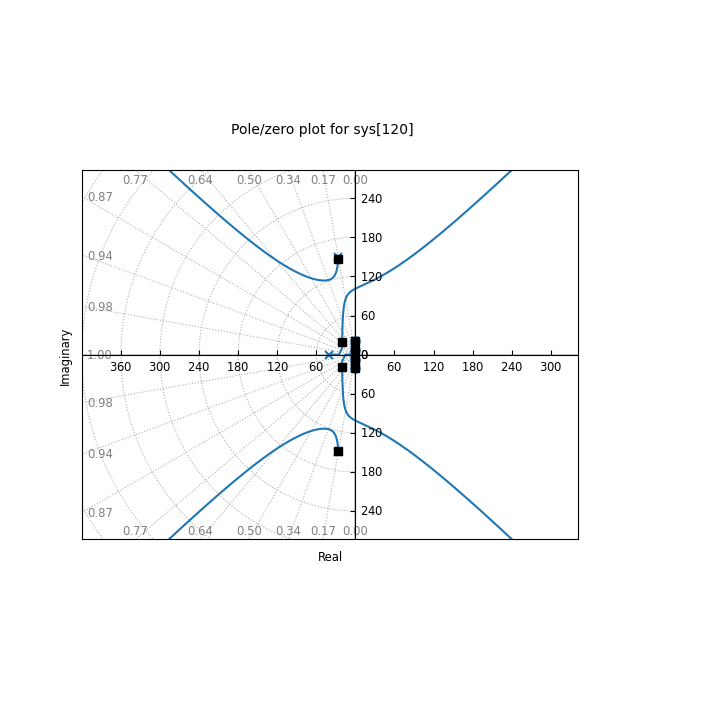

In [27]:
#Sistema não compensado com Controlador Proporcional
#P:  C_f = kc
ct.root_locus(sys_aa2d,np.linspace(0, 1, num=50000),grid='true',initial_gain=1.2*10**-4) #2DOF


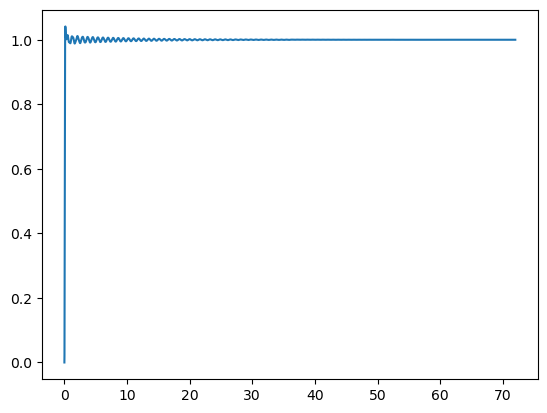

RiseTime: 0.07200002911687362
SettlingTime: 2.548801030737326
SettlingMin: 0.9427098420494857
SettlingMax: 1.0411382482511422
Overshoot: 4.113824825114359
Undershoot: 0
Peak: 1.0411382482511422
PeakTime: 0.15840006405712195
SteadyStateValue: 0.9999999999999987


In [28]:
#Resposta ao degrau do anel fechado

#anel fechado
kp=1.2993*10**-4      #Pgain (kp=1.2993 V/cm) #fator 10^-4 vem da conversão de unidades
controller=ct.tf(kp, 1, inputs='error', outputs='isv') #controlador prop 'kp'
error = ct.summing_junction(['xpref', '-xp'], 'error') #
sys_af2d=ct.interconnect([controller, sys_aa2d, error], inputs='xpref', outputs='xp')

# Step response for the system
plt.figure(2)
yout, T = step(sys_af2d)
#yout2, T2 = step(FT2)
#plt.plot(T.T, yout.T,T2.T, yout2.T)
#plt.gca().legend(('FT1','FT2'))
#plt.plot(T2.T, yout2.T)
plt.plot(T.T, yout.T)
plt.show(block=False)


S_FT2 = ct.step_info(sys_af2d, SettlingTimeThreshold=0.01)
for k in S_FT2:
    print(f"{k}: {S_FT2[k]}")

In [29]:
ct.damp(sys_af2d)

    Eigenvalue (pole)       Damping     Frequency
    -26.16    +147.3j        0.1749         149.6
    -26.16    -147.3j        0.1749         149.6
    -20.27    +21.07j        0.6933         29.23
    -20.27    -21.07j        0.6933         29.23
   -0.6653    +20.27j       0.03281         20.28
   -0.6653    -20.27j       0.03281         20.28
  -0.09596    +7.717j       0.01243         7.718
  -0.09596    -7.717j       0.01243         7.718


(array([149.5586334 , 149.5586334 ,  29.23238445,  29.23238445,
         20.2802195 ,  20.2802195 ,   7.7177645 ,   7.7177645 ]),
 array([0.17491126, 0.17491126, 0.69332227, 0.69332227, 0.03280712,
        0.03280712, 0.01243368, 0.01243368]),
 array([-26.15948884+147.25306778j, -26.15948884-147.25306778j,
        -20.26746318 +21.06566489j, -20.26746318 -21.06566489j,
         -0.66533558 +20.26930269j,  -0.66533558 -20.26930269j,
         -0.0959602   +7.71716791j,  -0.0959602   -7.71716791j]))

In [30]:
sys_aa2d

StateSpace(array([[-4.06504065e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 7.86382114e+06, -4.87826987e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.24560000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -1.83779593e+02, -1.57913670e+02,
        -1.99081079e+00,  0.00000000e+00, -5.02654825e-01,
        -6.33694756e-03,  2.92643410e+00],
       [ 0.00000000e+00

In [31]:
#teste: feedback system 
P = ct.tf(1, [1, 0], inputs='u', outputs='y')
C = ct.tf(10, [1, 1], inputs='e', outputs='u')
sumblk = ct.summing_junction(inputs=['r', '-y'], output='e')
T = ct.interconnect([P, C, sumblk], inputs='r', outputs='y')

P_ss=ct.tf2ss(ct.tf(1, [1, 0],inputs='u', outputs='y'))
C_ss=ct.tf2ss(ct.tf(10, [1, 1],inputs='e', outputs='u'))
sumblk = ct.summing_junction(inputs=['r', '-y'], output='e')
T_ss = ct.interconnect([P_ss, C_ss, sumblk], inputs='r', outputs='y')

P_ss2=ss(0,1,1,0,inputs='u', outputs='y')
C_ss2=ss(-1,1,10,0,inputs='e', outputs='u')
sumblk = ct.summing_junction(inputs=['r', '-y'], output='e')
T_ss2 = ct.interconnect([P_ss2, C_ss2, sumblk], inputs='r', outputs='y')


In [32]:
T_ss2

StateSpace(array([[ 0., 10.],
       [-1., -1.]]), array([[0.],
       [1.]]), array([[1., 0.]]), array([[0.]]))

In [33]:
T_ss

StateSpace(array([[ 0., 10.],
       [-1., -1.]]), array([[0.],
       [1.]]), array([[1., 0.]]), array([[0.]]))

In [34]:
C

TransferFunction(array([10]), array([1, 1]))

In [35]:
T

StateSpace(array([[ 0., 10.],
       [-1., -1.]]), array([[0.],
       [1.]]), array([[1., 0.]]), array([[0.]]))

In [36]:
ct.ss2tf(T)

TransferFunction(array([10.]), array([ 1.,  1., 10.]))

In [37]:
minreal(C*P/(1+C*P))

2 states have been removed from the model


TransferFunction(array([10.]), array([ 1.,  1., 10.]))

In [38]:
ct.tf2ss(minreal(C*P/(1+C*P)))

2 states have been removed from the model


StateSpace(array([[-1., -1.],
       [10.,  0.]]), array([[-1.],
       [ 0.]]), array([[ 0., -1.]]), array([[0.]]))